# Sequence Models 
## Welcome to today's workshop! 😁
In this notebook series, we will complement what is being covered by showcasing different popular language modeling techniques. We will go in detail through each technique, so by the end of the workshop you understand all basic elements and have confidence in implementing your own 

# Character-level language models 🤨

This type of model is one of the simplest out there. It is a **statistical** language model that predicts the next character in a sequence of text based on the previous characters. 
As opposed to other language models in which each word is first *tokenised*, character-level ones have a simpler approach: characters normally do not keep a semantic value.
Thus, the vocabulary these models will handle will only consist of characters

Objective of this notebook:
### Understand how a Recurrent Neural Network functions

# The Task:
Panama is a small Latin American country (and where I am from!). The file `streets.txt` contains the name of every street in the country (mostly sourced from [here](https://data.humdata.org/dataset/hotosm_pan_roads)).

What should new streets be named? Let's train a character-level LM to generate likely new names based on already existing ones.

![Calle en Panama](images/calle.jpg)


In [1]:
#Let us open the file and read the contents. 
streets = []

#It is important to keep our dataset clean! We will remove all special characters and convert the text to lowercase.
with open('streets.txt') as f:
    for line in f:
        line = line.lower()
        line = line.replace('[', '')
        line = line.replace(']', '')
        line = line.replace('"', '')
        line = line.replace("'", '')
        line = line.replace('(', '')
        line = line.replace(')', '')
        line = line.replace('{', '')
        line = line.replace('}', '')
        line = line.replace('/', '')
        linr = line.replace('#', '')
        line = line + "\n"
        streets.append(line.strip())


#Let us print the contents of the file, so you know what you are working with.
import random
for i in range(5):
    print(random.choice(streets))

#Some more important information about the dataset:
chars = list(set(''.join(streets)))
chars.append("\n")
data_size, vocab_size = len(streets), len(chars)
print("The dataset has", data_size, "street names and", vocab_size, "unique characters.")

calle cirprés
fairchild
avenida fabio díaz
calle miller
calle 1ra la mireya
The dataset has 4972 street names and 55 unique characters.


Calle means street in Spanish 😁

Anyway, we have 54 characters (a-z, numbers, and vowels with accent marks.) as well as the newline character `\n`. This character indicates the end of the streeet name. 

Now, we are going to create a **dictionary** to map each character to an index from 0 to 55. We will also create another dictionary that does the opposite, mapping from index to character. This will make calculating the probability distribution a lot easier.

In [2]:
character_to_index = { ch:i for i,ch in enumerate(sorted(chars)) }
index_to_character = { i:ch for i,ch in enumerate(sorted(chars)) }
print("Take a look at the way these dictionaries hold the data")
print({k: character_to_index[k] for k in list(character_to_index.keys())[16:26]})

Take a look at the way these dictionaries hold the data
{'a': 16, 'b': 17, 'c': 18, 'd': 19, 'e': 20, 'f': 21, 'g': 22, 'h': 23, 'i': 24, 'j': 25}


Time to get started with the real stuff!

We will achieve our goal through three functions. 
The first function we will work on is `sample`. The goal of this function is to *sample* values of the dataset given a probability distribution.
In simple words, this means randomly choosing the next letter based on their probability, considering the previous letters in the word.

In [3]:
import numpy as np

##First, let us define the softmax function
###The softmax function turns a vector of real numbers into a probability distribution. It is commonly used in Machine Learning
def softmax(x):
    e_x = np.exp(x - np.max(x)) # x is subtracted by np.max(x) to prevent exploding gradients
    return e_x / e_x.sum(axis=0)



#okay time for sample!
def sample(trained_parameters, char_to_ix):
    ###################################################################
    #####Function inputs########
    # trained_parameters: dictionary containing the trained parameters (weights)
    # char_to_ix: dictionary mapping characters to indices
    

    Waa, Wax, Wya, by, b = trained_parameters['Waa'], trained_parameters['Wax'], trained_parameters['Wya'], trained_parameters['by'], trained_parameters['b']
    
    vocab_size = by.shape[0]
    #n_a is the number of hidden neurons
    n_a = Waa.shape[1]
    
    
    
    x = np.zeros((vocab_size, 1))
    a_prev = np.zeros((n_a, 1))
    #a_prev is a vector containing information about the previous letter
    #It will initially be zeros, as there is no previous letter

    indices = []
    idx = -1
    counter = 0
    newline_character = char_to_ix['\n']

    # This loop will predict the next character based on the previous character continuously until a newline character is predicted (meaning the word is complete)
    while (idx != newline_character and counter != 50):

        # Forward propagation
        a = np.tanh(Waa.dot(a_prev) + Wax.dot(x) + b)
        y = softmax(Wya.dot(a) + by)

        # Sample from a probability distribution
        idx = np.random.choice(vocab_size , 1, p = y.flatten())
        indices.append(idx[0])

        x = np.zeros((vocab_size, 1))
        x[idx] = 1

        a_prev = a

        counter += 1

    if (counter == 50):
        indices.append(newline_character)
        
        
        
    #indices is a list containing the indices of the sampled characters
    return indices

Ok great 👍 
Our next function is 
# Train
This is the heart of the model, so pay attention 🤓

In [4]:

def train(X, Y, a_prev, parameters, lr = 0.01):
    ###################################################################
    #####Function inputs########
    #X: list of integers, where each integer is a number that maps to a character in the vocabulary.
    #Y: list of integers, exactly the same as X but shifted one index to the left.
    #a_prev: previous hidden state
    #parameters: python dictionary containing:
    #                    Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
    #                    Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
    #                    Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
    #                    b --  Bias, numpy array of shape (n_a, 1)
    #                    by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    #lr: learning rate for the model.
    
    #Returns:
    #loss -- value of the loss function (cross-entropy)
    #parameters -- python dictionary containing:
    #                    dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
    #                    dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
    #                    dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
    #                    db -- Gradients of bias vector, of shape (n_a, 1)
    #                    dby -- Gradients of output bias vector, of shape (n_y, 1)
    #a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    
    
    


    # Step 1 : Forward propagation

    # Initialize x, a and y_hat as empty dictionaries
    x, a, y_hat = {}, {}, {}
    a[-1] = np.copy(a_prev)
    # initialize your loss to 0
    loss = 0
    #The following loop will predict the next character in the input sequence and calculate the loss
    for t in range(len(X)):

        # Set x[t] to be the one-hot vector representation of the t'th character in X. 
        # if X[t] == None, we just have x[t]=0. This is used to set the input for the first timestep to the zero vector.
        x[t] = np.zeros((vocab_size, 1))
        if (X[t] != None):
            x[t][X[t]] = 1

        # Run one step forward of the RNN
        Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
        a_next = np.tanh(np.dot(Wax, x[t]) + np.dot(Waa, a[t-1]) + b)  # hidden state
        p_t = softmax(np.dot(Wya, a_next) + by)  # unnormalized log probabilities for next chars # probabilities for next chars
        a[t], y_hat[t] = a_next, p_t  # store hidden state and prediction
        
        # Update the loss by substracting the cross-entropy term of this time-step from it.
        loss -= np.log(y_hat[t][Y[t], 0])
    cache = (y_hat, a, x)



    # Step 2 : Backward propagation
    # Initialize gradients as an empty dictionary
    gradients = {}
    # Retrieve from cache and parameters
    (y_hat, a, x) = cache
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']

    # each one should be initialized to zeros of the same dimension as its corresponding parameter
    gradients['dWax'], gradients['dWaa'], gradients['dWya'] = np.zeros_like(Wax), np.zeros_like(Waa), np.zeros_like(Wya)
    gradients['db'], gradients['dby'] = np.zeros_like(b), np.zeros_like(by)
    gradients['da_next'] = np.zeros_like(a[0])

    # Backpropagate through time
    #This is done by calculating the gradients of the loss with respect to the parameters
    for t in reversed(range(len(X))):
        dy = np.copy(y_hat[t])
        dy[Y[t]] -= 1
        gradients['dWya'] += np.dot(dy, a[t].T)
        gradients['dby'] += dy
        da = np.dot(parameters['Wya'].T, dy) + gradients['da_next']  # backprop into h
        daraw = (1 - a[t] * a[t]) * da  # backprop through tanh nonlinearity
        gradients['db'] += daraw
        gradients['dWax'] += np.dot(daraw, x[t].T)
        gradients['dWaa'] += np.dot(daraw, a[t-1].T)
        gradients['da_next'] = np.dot(parameters['Waa'].T, daraw)


    # Step 3 : Gradient clipping
    maxValue = 5
    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
    # clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby]
    for gradient in [dWax, dWaa, dWya, db, dby]:
        np.clip(gradient, np.negative(maxValue), maxValue, out=gradient)
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}

    # Step 4: Update weights
    parameters['Wax'] += -lr * gradients['dWax']
    parameters['Waa'] += -lr * gradients['dWaa']
    parameters['Wya'] += -lr * gradients['dWya']
    parameters['b']  += -lr * gradients['db']
    parameters['by']  += -lr * gradients['dby']
    
    return loss, parameters, a[len(X) - 1]

We have defined how to predict new values (**sampling**) and how to train the model so that it learns the probabilistic relationship between different characters (**train**). Let us now define the **model** itself!

In [5]:
def model(data, ix_to_char, char_to_ix, num_it, n_a, sample_number, unique_chars):
    ###################################################################
    #####Function inputs########
    # data: the dataset of street names
    # ix_to_char: dictionary that maps the index to a character
    # char_to_ix: dictionary that maps a character to an index
    # num_it: amount of iterations for training
    # n_a: number of units of the RNN cell
    # sample number: amount of street names you want to sample every iteration
    # unique_chars: number of unique characters found in the text, size of the vocabulary
    losses = []
    
    
    n_x, n_y = unique_chars, unique_chars
    #initialise the parameters with random small values
    Wax = np.random.randn(n_a, n_x) * 0.01  # input to hidden
    Waa = np.random.randn(n_a, n_a) * 0.01  # hidden to hidden
    Wya = np.random.randn(n_y, n_a) * 0.01  # hidden to output
    b = np.zeros((n_a, 1))  # hidden bias
    by = np.zeros((n_y, 1))  # output bias
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b, "by": by}
    
    #initialise the loss 
    loss = -np.log(1.0/unique_chars)*sample_number
    
    #make the input random every iteration
    np.random.shuffle(data)
    
    #initialise the previous state to zero
    a_prev = np.zeros((n_a, 1))
    
    #Training
    for i in range(num_it):
        index = i % len(data)
        X = [None] + [char_to_ix[ch] for ch in data[index]]
        Y = X[1:] + [char_to_ix["\n"]]
        current_loss, parameters, a_prev = train(X, Y, a_prev, parameters)
        #smooth the loss
        loss = loss * 0.999 + current_loss * 0.001
        
        #every 2000 iterations, generate "sample_number" characters to see the progress of the model
        if i % 2000 == 0:
            print("Iteration: ", i, "Loss: ", loss)
            for j in range(sample_number):
                sampled_indices = sample(parameters, char_to_ix)
                txt = ''.join(ix_to_char[ix] for ix in sampled_indices)
                txt = txt[0].upper() + txt[1:]  # capitalize first character
                print ('%s' % (txt, ), end='')
            print("\n")
            losses.append(loss)
    return parameters, losses

Now, it's time to actually get this baby running! We just have to call the `model` function we just defined

In [6]:
parameters, losses = model(streets, index_to_character, character_to_index, num_it = 55000, n_a = 50, sample_number = 8, unique_chars = vocab_size)

Iteration:  0 Loss:  32.0867161626669
Ï9y7az1´ac1óuktg–uvñuìu66l0-ì-6cïj97w.níwu´k
,–-yq
Búqaevqly.iíú-hmm #ó#i1zkìp6 8úgmhée69
.rlóséñépa0c
Eq
Éá67ú´5tm,á
#–3dó40cr
7–u#2–g7.#caü a´fqé49puug,ip9újqúl328udmfyp3333-ú7


Iteration:  2000 Loss:  38.842175469663246
 8,calle lesíerr´a nar luenve

Invirte del f l
Ixabria
Áacalle lrñavenida n0lare
Cares malle jst numecasrb
Emee
De


Iteration:  4000 Loss:  34.658072576608774
Davon 51a erterocalatoentororortito
Calle mintro
Avanida coales
E

Palle den
Ovejada coratinavíavía
Carasito


Iteration:  6000 Loss:  33.314879063251375
Calle rastrebguesíporrallayro
Avenidaridella da menqanaroyasqascezaserded
Cosidecoste
Calle linidabananoegino aoroes hantez
Culle bieycolle labaavíaloe deracaregéagonoypaneyó
Carrosorarvmosdalle belderallaro buetriozarderanaf
 begía portrdes verada
Calle el pirerarira oyavenida caitanalosorio 2 ger


Iteration:  8000 Loss:  31.101020324460105
Avenida el errtcaller
Vía ca
Avenida gurrigo
Avenita norter
Pgano
Avanida 10 oe

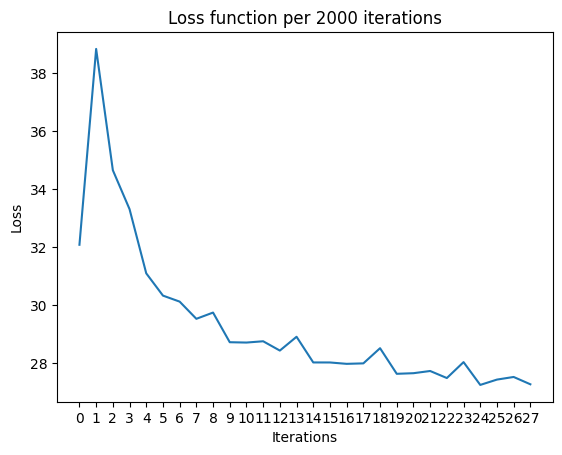

In [7]:
import matplotlib.pyplot as plt
plt.plot(losses)
#make each element in x axis 2000 iterations
plt.xticks(np.arange(0, len(losses), step=1), labels=[int(i) for i in range(len(losses))])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss function per 2000 iterations')
plt.show()